In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from scipy.stats import norm, skew
import seaborn as sns

In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
train.head()
#Tahmin işlemi için gerekli olmadığından, 'Id' sütununu kaldırılır.
test_id = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id",axis = 1, inplace = True)

In [4]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)
train['SalePrice'].describe()

Train set size: (1460, 80)
Test set size: (1459, 79)


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


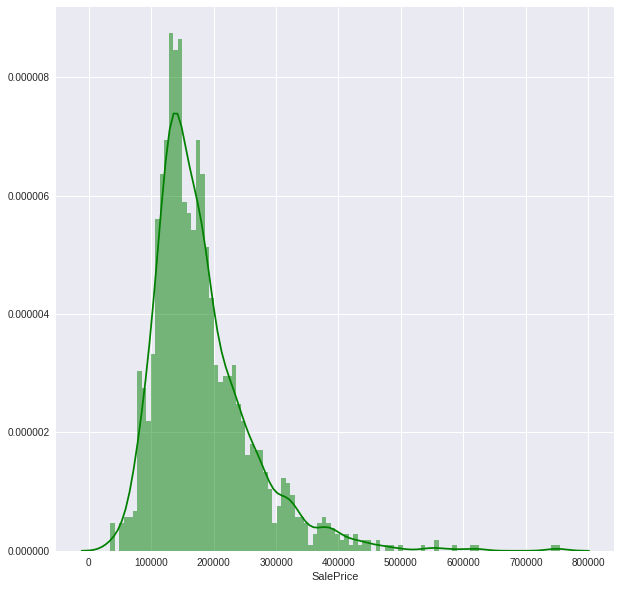

In [5]:
plt.figure(figsize=(10, 10))
sns.distplot(train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.5});

Train verisetinin korelasyon matrisi oluşturulur. Verilerin birbiri ile ilşkisini görebilmek için.

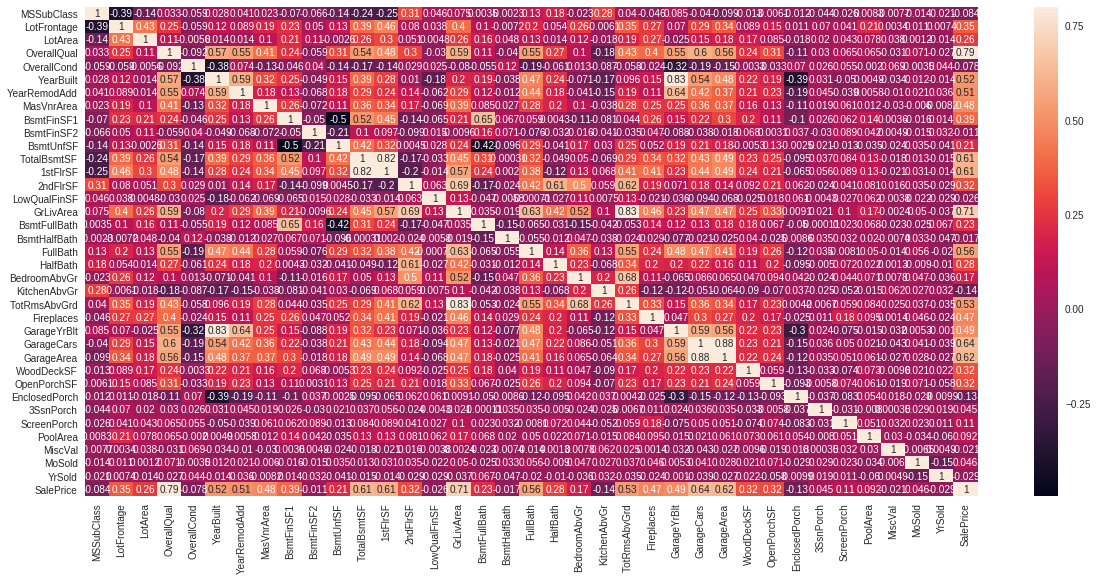

In [6]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

Ev fiyatları ile en ilişkili özelliklere bakılır bu yüzden eşik değeri 0.5 olarak belirlenmiş ve yukarıdaki korelasyon matrisinden de hareketle korelasyon değeri 0.5'in üzerinde olan özellikler dikkate alınır.

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'SalePrice'],
      dtype='object')


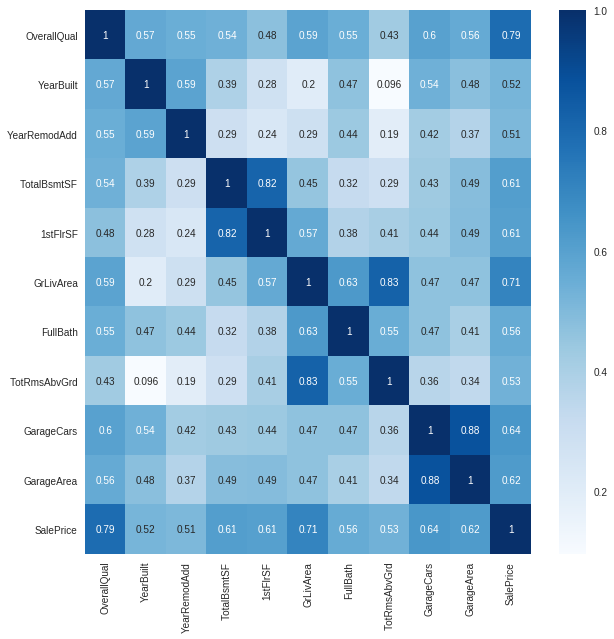

In [7]:
most_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[most_corr_features].corr(),annot=True,cmap="Blues")
print(most_corr_features)

In [8]:
# Yukarıdaki grafiği yorumladığımızda, SalePrice(Evin Satış Fiyatı) ile en ilişkili özelliğin OverallQual olduğu görülmektedir.
#Belirlenen eşik korelasyon değerini aşan özellikler, 
correlated_cols = ['OverallQual','YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','GarageCars']


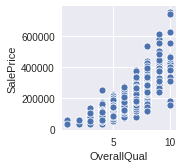

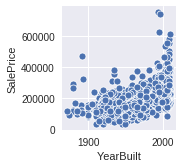

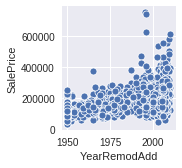

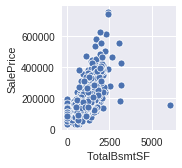

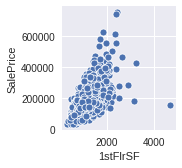

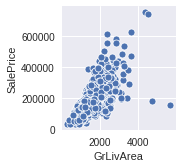

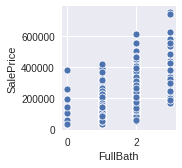

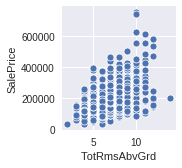

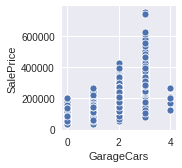

In [9]:
#Yukarıdaki Çıktılara göre outlier(ayrık) veriler tespit edilir ve bu veriler kaldırılır.
# GrlivArea >5000 
# 1stFlrSF > 4000
# TotalBsmtSF >6000
#Belirlenen bu özelliklere göre, bu alanlarda yer alan ayrık veriler tespit edilir.
data = pd.concat([train['SalePrice'], train[correlated_cols]], axis=1)
for lst in correlated_cols:
    sns.pairplot(data, y_vars=['SalePrice'], x_vars=lst)
outliers = {"TotalBsmtSF": 6000,"1stFlrSF": 4000, "GrLivArea": 5000}
#Olusan grafiğe göre outlier(ayrık) veriler temizlenir.
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['1stFlrSF']>4000) & (train['SalePrice']<200000)].index)
train = train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index)


test = test.drop(test[(test['GrLivArea']>4000)].index)
test = test.drop(test[(test['1stFlrSF']>4000)].index)
test = test.drop(test[(test['TotalBsmtSF']>6000)].index)



#data = pd.concat([train['SalePrice'], train[correlated_cols]], axis=1)
#for lst in correlated_cols:
    #sns.pairplot(data, y_vars=['SalePrice'], x_vars=lst)

In [10]:
categorical_features = train.select_dtypes(include=['object']).columns
categorical_features
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
train_num = train[numerical_features]
train_cat = train[categorical_features]

In [11]:
total = train_num.isnull().sum().sort_values(ascending=False)# train verisetinde yer alan eksik veri sayısını gösterir.
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head() # hangi özellikte kaç veri eksik olduğunu gösterir

,Total
LotFrontage,259
GarageYrBlt,81
MasVnrArea,8
YrSold,0
BsmtFinSF2,0


In [12]:
train_num = train_num.fillna(train_num.median())
total = train_num.isnull().sum().sort_values(ascending=False)# train verisetinde yer alan eksik veri sayısını gösterir.
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data.head() # hangi özellikte kaç veri eksik olduğunu gösterir

,Total
YrSold,0
MoSold,0
GrLivArea,0
LowQualFinSF,0
2ndFlrSF,0


In [13]:
train.SalePrice = np.log1p(train.SalePrice )
y = train.SalePrice

In [14]:
from scipy.stats import skew 
skewness = train_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
MasVnrArea        2.693554
OpenPorchSF       2.337421
LotFrontage       1.719086
WoodDeckSF        1.544214
MSSubClass        1.405563
GrLivArea         1.009951
BsmtUnfSF         0.919955
1stFlrSF          0.886723
2ndFlrSF          0.812121
BsmtFinSF1        0.764002
OverallCond       0.690324
HalfBath          0.679351
TotRmsAbvGrd      0.659822
Fireplaces        0.631409
BsmtFullBath      0.589751
TotalBsmtSF       0.511177
MoSold            0.215211
BedroomAbvGr      0.212107
OverallQual       0.200579
GarageArea        0.131612
YrSold            0.095322
FullBath          0.031239
GarageCars       -0.342025
YearRemodAdd     -0.501322
YearBuilt        -0.611665
GarageYrBlt      -0.676645
dtype: float64

In [15]:
train_cat = pd.get_dummies(train_cat)
train_cat.shape
train_cat.head()
str(train_cat.isnull().values.sum())

'0'

In [16]:
train = pd.concat([train_cat,train_num],axis=1)
print(train.shape)

(1458, 287)


In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size = 0.3,random_state= 0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1020, 287) (438, 287) (1020,) (438,)


In [18]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train= scaler.fit_transform(train)
n_col=train.shape[1]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PCA(Temel Bileşen Analizi) 'nın amacı, verilerin çeşitliliğini korurken, birbirleriyle korelasyonlu değişkenler içeren verilerin boyutsallığını en aza indirmektir. Çok fazla yayılmayan daha düşük varyansa sahip olan değişkenler daha düşük bir boyuta yansıtılacaktır.

In [19]:
from sklearn.decomposition import PCA
pca=PCA(n_components=n_col)
train_components=pca.fit(train)
test_components=pca.fit(X_test)
pca.components_

array([[-1.15947100e-07, -2.17058814e-06, -4.08619158e-07, ...,
         4.54517874e-03,  1.66570493e-06, -8.66358606e-06],
       [ 8.44554713e-06, -2.01959286e-05, -3.27043982e-06, ...,
        -6.25522406e-02, -3.30940307e-04, -4.79517770e-05],
       [-4.77627938e-06, -3.96234204e-05, -1.12135759e-05, ...,
        -1.04600031e-01,  1.03663968e-05, -1.47822514e-05],
       ...,
       [-0.00000000e+00, -1.15176897e-28, -1.14261714e-28, ...,
        -4.93038066e-32,  3.82104501e-31, -1.57772181e-30],
       [ 0.00000000e+00, -8.15620294e-30,  3.70695382e-30, ...,
        -7.70371978e-34,  3.69778549e-32,  1.35585468e-31],
       [ 4.47213568e-01,  4.47213568e-01,  4.47213568e-01, ...,
         8.04911693e-16, -1.93005334e-14,  2.46807783e-15]])

In [20]:
pca.get_covariance()

array([[ 4.55576105e-03, -2.40326845e-04, -6.26939594e-05, ...,
        -1.48375704e-01,  4.09600535e-03,  1.23298120e-03],
       [-2.40326845e-04,  4.98678202e-02, -7.20980534e-04, ...,
        -1.70632060e+00, -9.50858385e-04,  7.31429527e-03],
       [-6.26939594e-05, -7.20980534e-04,  1.35418952e-02, ...,
        -4.45127112e-01,  3.13469797e-03, -1.00310335e-02],
       ...,
       [-1.48375704e-01, -1.70632060e+00, -4.45127112e-01, ...,
         1.73225709e+05,  5.74569240e+01, -2.12229502e+01],
       [ 4.09600535e-03, -9.50858385e-04,  3.13469797e-03, ...,
         5.74569240e+01,  7.40770927e+00, -3.24044178e-01],
       [ 1.23298120e-03,  7.31429527e-03, -1.00310335e-02, ...,
        -2.12229502e+01, -3.24044178e-01,  1.69384450e+00]])

In [21]:
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor

lab_enc = preprocessing.LabelEncoder() # bunu açıkla
Y = lab_enc.fit_transform(y)
print(Y.shape)
rf = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
rf.fit(train,Y)
#print(rf.feature_importances_)

(1458,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Support Vector Machine(SVM) Sınıflayıcıların bir çeşit regresyon uygulaması olan SVR kullanılarak model eğitilmiştir. Problem lineer bir problem olmadığı için rbf kernel'ı tercih edilmiştir.

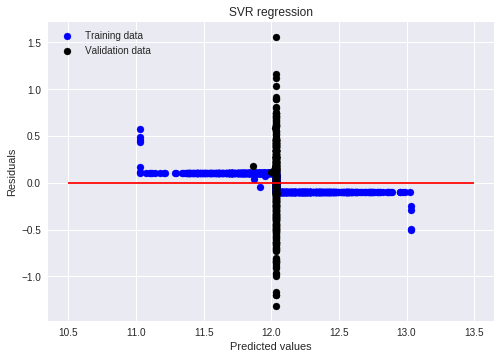

In [22]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
regressor=SVR(kernel='rbf',gamma='auto')

regressor.fit(X_train,y_train)
test_pre = regressor.predict(X_test)
train_pre = regressor.predict(X_train)

plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
plt.title("SVR regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

0.8993157818055529


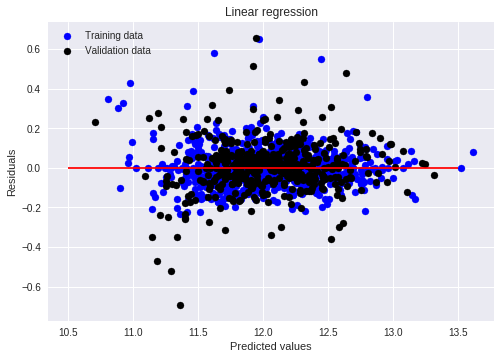

In [23]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

print(r2_score(y_test,test_pre))

plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

In [24]:
predictx=lr.predict(test)
print(predictx.shape)
my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': predictx})
my_submission.to_csv('submission.csv', index=False)

ValueError: could not convert string to float: 'RH'